# 0 - PLANNING

- Main objective for this 0th cycle is a model with good performance, to be tested against Kaggle's hidden result through submission<br><br>

- To streamline modeling, a few simplifications might be made for now, as well as some steps might be skipped (to be rescued on future cycles)<br><br>

- After a good performance and discovery (EDA) are achieved, final model could be thought of being deployed somehow<br><br>

- Problem posed here is a binary classification one (should be checked whether it's imbalanced)

# 1 - SETUP

In [5]:
import random
import re
from IPython.display import HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import mode
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [6]:
%matplotlib inline

def jupyter_settings():
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = 20, 10
    plt.rcParams['font.size'] = 24
    sns.set()
    
    display(HTML('<style>.container{width:95% !important;}</style>'))
    
jupyter_settings()

In [7]:
df = pd.read_csv('../data/train.csv')

In [8]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
215,216,1,1,"Newell, Miss. Madeleine",female,31.0,1,0,35273,113.2750,D36,C
452,453,0,1,"Foreman, Mr. Benjamin Laventall",male,30.0,0,0,113051,27.7500,C111,C
856,857,1,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S
139,140,0,1,"Giglio, Mr. Victor",male,24.0,0,0,PC 17593,79.2000,B86,C
390,391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,S


# 2 - DATA DESCRIPTION

In [9]:
df2 = df.copy() 

In [10]:
# Renaming columns to make work easier
df2.columns = [x.upper() for x in df2.columns]

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PASSENGERID  891 non-null    int64  
 1   SURVIVED     891 non-null    int64  
 2   PCLASS       891 non-null    int64  
 3   NAME         891 non-null    object 
 4   SEX          891 non-null    object 
 5   AGE          714 non-null    float64
 6   SIBSP        891 non-null    int64  
 7   PARCH        891 non-null    int64  
 8   TICKET       891 non-null    object 
 9   FARE         891 non-null    float64
 10  CABIN        204 non-null    object 
 11  EMBARKED     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [12]:
# Passenger ID is a primary key, fortunatelly
len(df2['PASSENGERID'].unique())

891

- Quite small dataset, shouldn't pose time performance problems; however, eventual dropouts could have significant impact over model performance<br><br>

- NAs on CABIN, AGE and EMBARKED, with effect size on decreasing order
    - CABIN feature might have significant impact over model performance (heuristically speaking); should be properly filled
    - Same goes for AGE, but it should be easier to fill than CABIN
    - EMBARKED has only 2 NAs, could be dropped or filled with almost no worries<br><br>

- Data types seemingly ok, except possibly for TICKET (shall be explored below)

In [13]:
int_count = 0
str_acc = []
for x in df2['TICKET']:
    try:
        int(x)
        int_count += 1
    except:
        str_acc.append(x)

f'{int_count / df2.shape[0] * 100:.2f}% are indeed integers. Sample of remaining ones: {random.sample(str_acc, 5)}'

"74.19% are indeed integers. Sample of remaining ones: ['PC 17601', 'PC 17611', 'PC 17758', 'CA. 2343', 'A/5 21171']"

- Non-integer (str) part apparently has some meaning. Let's try to keep only the numeric part and see if it inserts duplicates on the dataset.<br>
If not, we will follow this way.

## 2.0 - Data cleaning

In [14]:
# For now, there are some duplicate tickets already
f"{len(df2['TICKET'].unique())} are unique, that is {len(df2['TICKET'].unique()) / df2.shape[0] * 100:.2f}%"

'681 are unique, that is 76.43%'

In [15]:
# Number of tickets that appear more than once
len([x for x in df2['TICKET'] if list(df2['TICKET']).count(x) > 1])

344

In [16]:
# Dummy value still not used. Shall be used below to fill edge cases
df2[df2['TICKET'] == '0']

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED


In [17]:
new_col = []
outliers = []
for x in df2['TICKET']:
    try:
        new_col.append(int(x))  # Cast regular cases
    except:
        if match := re.findall('\d+', x):  # Gets only numeric part    
            new_col.append(int(match[0]))
        else:  # Edge cases
            outliers.append(x)
            new_col.append(0)

In [18]:
# Could be people that didn't buy a ticket, but else awaited in line
outliers

['LINE', 'LINE', 'LINE', 'LINE']

In [19]:
# It seems some duplicates were inserted, more precisely 45, that is, a ~3% decrease to 71.5%
len(set(new_col))

636

In [20]:
# Finally, substitute original values
df2['TICKET'] = new_col

## 2.1 - Casting

In [21]:
# TICKET was "naturally" cast by the procedure in the last section
df2.dtypes

PASSENGERID      int64
SURVIVED         int64
PCLASS           int64
NAME            object
SEX             object
AGE            float64
SIBSP            int64
PARCH            int64
TICKET           int64
FARE           float64
CABIN           object
EMBARKED        object
dtype: object

## 2.2 - Dealing with NAs

In this this 0th cycle, simple rules shall be adopted
- CABIN: feature shall be left aside for now
- AGE: (round) average value of ages in the dataset shall be used for filling
- EMBARKED: mode shall be used to fill the only 2 missing values

In [22]:
df2 = df2.loc[:, ~df2.columns.isin(['CABIN'])]

In [23]:
df2['AGE'].fillna(round(df2['AGE'].mean()), inplace=True)

In [24]:
df2['EMBARKED'].fillna(mode(df2['EMBARKED'])[0][0], inplace=True)

In [25]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PASSENGERID  891 non-null    int64  
 1   SURVIVED     891 non-null    int64  
 2   PCLASS       891 non-null    int64  
 3   NAME         891 non-null    object 
 4   SEX          891 non-null    object 
 5   AGE          891 non-null    float64
 6   SIBSP        891 non-null    int64  
 7   PARCH        891 non-null    int64  
 8   TICKET       891 non-null    int64  
 9   FARE         891 non-null    float64
 10  EMBARKED     891 non-null    object 
dtypes: float64(2), int64(6), object(3)
memory usage: 76.7+ KB


## 2.3 - "A priori" statistics

In [26]:
# PASSENGERID won't be a predictor variable
# SURVIVED (target) is known to be binary, but let's consider it anyway
df2.loc[:, df2.columns != 'PASSENGERID'].describe()

,SURVIVED,PCLASS,AGE,SIBSP,PARCH,TICKET,FARE
count,891.000000,891.000000,891.000000,891.000000,891.000000,8.910000e+02,891.000000
mean,0.383838,2.308642,29.758889,0.523008,0.381594,2.268235e+05,32.204208
std,0.486592,0.836071,13.002570,1.102743,0.806057,5.015518e+05,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,1.176700e+04,7.910400
50%,0.000000,3.000000,30.000000,0.000000,0.000000,1.101520e+05,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,3.470615e+05,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,3.101317e+06,512.329200


- On 1st sight (aiming mainly at the min, max and quartiles), only PCLASS seems not to have any behavior indicating the presence of outliers
    - TICKET, FARE and AGE might be the most affected
    - SIBSP and PARCH only slightly

In [27]:
# Target slightly imbalanced
# Point to be aware of in the DATA PREPARATION step
df2['SURVIVED'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: SURVIVED, dtype: float64

In [28]:
# As for the remaining (categorical) features
cat = df2.select_dtypes(exclude=['int64','float64'])
cat.columns

Index(['NAME', 'SEX', 'EMBARKED'], dtype='object')

In [29]:
cat['SEX'].value_counts()

male      577
female    314
Name: SEX, dtype: int64

In [30]:
cat['EMBARKED'].value_counts()

S    646
C    168
Q     77
Name: EMBARKED, dtype: int64

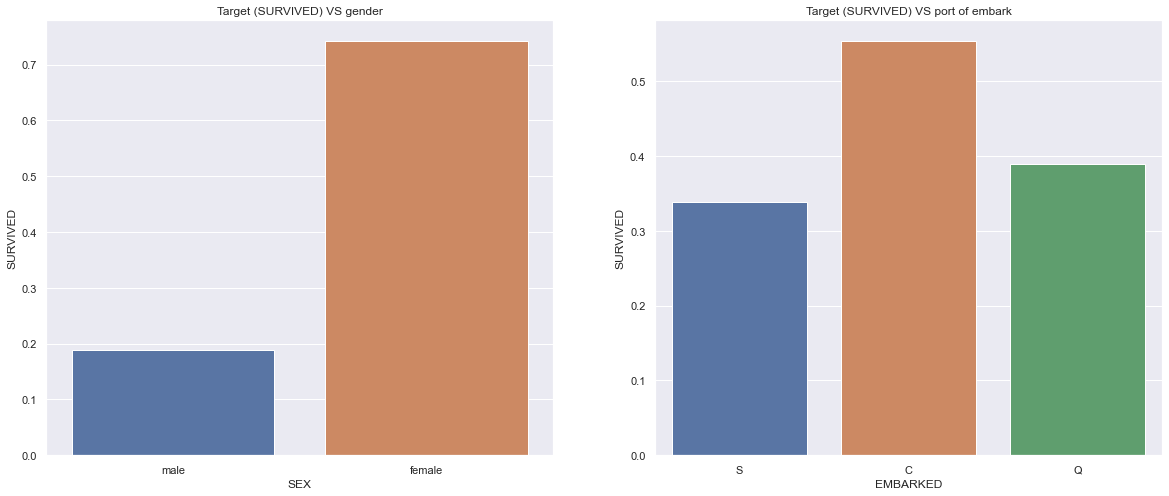

In [31]:
with plt.rc_context():
    plt.rcParams['figure.figsize'] = 20, 8
    
    plt.subplot(1, 2, 1);
    sns.barplot(x='SEX', y='SURVIVED', data=df2, ci=0);
    plt.title('Target (SURVIVED) VS gender');

    plt.subplot(1, 2, 2);
    sns.barplot(x='EMBARKED', y='SURVIVED', data=df2, ci=0);
    plt.title('Target (SURVIVED) VS port of embark')

- Female rate of survival is quite bigger (the premise "women go first" might have applied for the embark to the emergency boats)<br><br>

- At least visually, the Cherbourg port seems to have a bigger rate of survival, which is curious, but I cannot figure out any reasonable explanation for the time being

# 3 - FEATURE ENGINEERING

For the time being (this 0th cycle), no new feature shall be devised

In [32]:
df3 = df2.copy()

# 4 - DATA FILTERING

In [33]:
df4 = df3.copy()

NAME feature shouldn't bring much more information besides PASSENGERID, so it will be dropped 

In [34]:
df4 = df4.loc[:, ~df4.columns.isin(['NAME'])]

# 5 - EDA

In [35]:
df5 = df4.copy()

For the time being (this 0th cycle), no deep exploratory step shall be carried on (besides the uni and bivariate visualizations below).<br>
The main objective for the moment is to have a first draft of a model.

## 5.0 - Univariate analysis

As suggested "a priori" at section 2.3:
- Target variable is slightly imbalanced → shall be left untouched in this 0th cycle
- TICKET, FARE and AGE are the most affected by outliers (in this order) → to be rescaled with RobustScaler
- SIBSP and PARCH present some too, but in a more moderate range → to be rescaled with RobustScaler, only to be certain
- PCLASS is well-behaved but not normal distributed → to be rescaled with MinMaxScaler

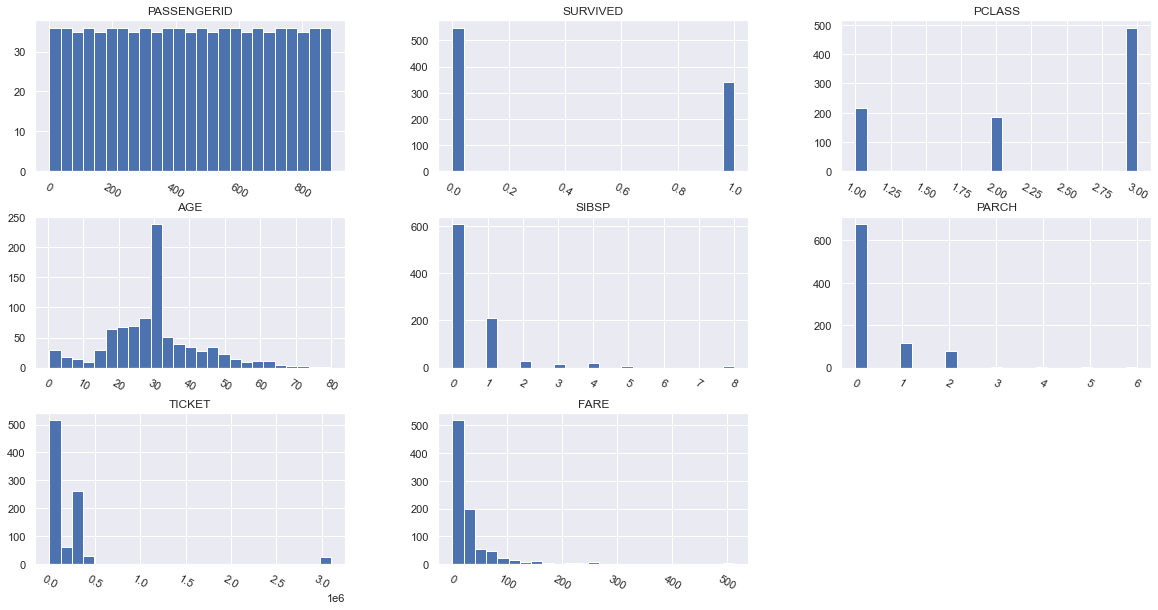

In [36]:
df5.hist(bins=25, xrot=-30);

## 5.1 - Bivariate analysis

A few conclusions from a fast visual analysis:
- Target VS predictors
    - High number of relatives onboard (high values of SIBSP and PARCH) seems to lead to lower chance of survival, which makes sense (one wouldn't want to abandon one's family, but to save everybody)
    - Very rich people (high FARE) seems to have a higher chance of survival<br><br>
    
- Predictors among themselves (mainly correlations, over which no action will be taken in this 0th cycle)
    - PCLASS and TICKET (or FARE) seems to have some correlation, which makes sense
    - AGE and SIBSP seems to have some correlation, which also makes sense

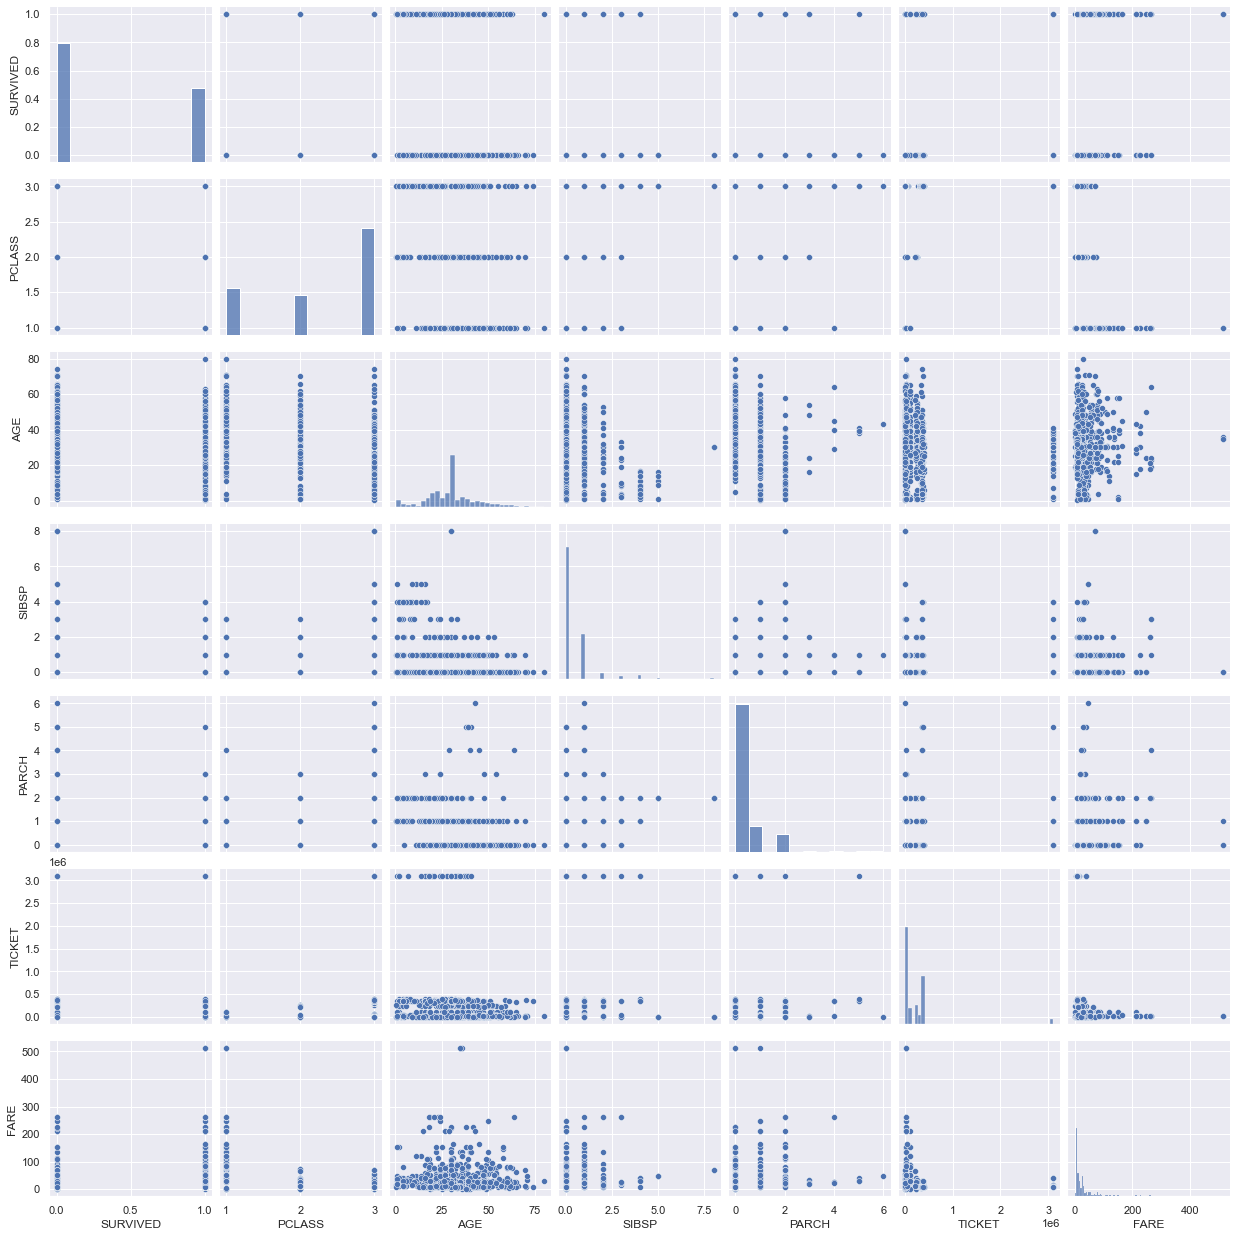

In [37]:
sns.pairplot(df5.loc[:, df5.columns != 'PASSENGERID']);

# 6 - DATA PREPARATION

In [38]:
df6 = df5.copy()

In [39]:
# Same statistics gathered earlier (section 2), brought up again just for comparison (below)
df6.describe()

,PASSENGERID,SURVIVED,PCLASS,AGE,SIBSP,PARCH,TICKET,FARE
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,8.910000e+02,891.000000
mean,446.000000,0.383838,2.308642,29.758889,0.523008,0.381594,2.268235e+05,32.204208
std,257.353842,0.486592,0.836071,13.002570,1.102743,0.806057,5.015518e+05,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000e+00,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,1.176700e+04,7.910400
50%,446.000000,0.000000,3.000000,30.000000,0.000000,0.000000,1.101520e+05,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,3.470615e+05,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,3.101317e+06,512.329200


## 6.0 - Scaling

Some of the algorithms to be used in the modeling step do not require scaling (such as the tree-based), but we will proceed with it anyway due to the remaining ones

In [40]:
for x in ('TICKET', 'FARE', 'AGE', 'SIBSP', 'PARCH'):
    rs = RobustScaler()
    fit_rs = rs.fit(df6[[x]])
    df6[x] = fit_rs.transform(df6[[x]])
    with open( f'../parameters/{x}.pkl', 'wb') as f:  # Save for a possible future inverse transform
        pickle.dump(fit_rs, f)

In [41]:
mm = MinMaxScaler()
fit_mm = mm.fit(df6[['PCLASS']])
df6['PCLASS'] = fit_mm.transform(df6[['PCLASS']])
with open( f'../parameters/PCLASS.pkl', 'wb') as f:  # Save for a possible future inverse transform
    pickle.dump(fit_mm, f)

In [42]:
df6.describe()

,PASSENGERID,SURVIVED,PCLASS,AGE,SIBSP,PARCH,TICKET,FARE
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,0.654321,-0.018547,0.523008,0.381594,0.347967,0.768745
std,257.353842,0.486592,0.418036,1.000198,1.102743,0.806057,1.495855,2.152200
min,1.000000,0.000000,0.000000,-2.275385,0.000000,0.000000,-0.328523,-0.626005
25%,223.500000,0.000000,0.500000,-0.615385,0.000000,0.000000,-0.293429,-0.283409
50%,446.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,668.500000,1.000000,1.000000,0.384615,1.000000,0.000000,0.706571,0.716591
max,891.000000,1.000000,1.000000,3.846154,8.000000,6.000000,8.921008,21.562738


## 6.1 - Encoding

In [43]:
df6 = pd.get_dummies(df6, columns=['SEX', 'EMBARKED'])
df6.columns = [x.upper() for x in df6.columns]

In [44]:
# Ok, all set to proceed
df6

,PASSENGERID,SURVIVED,PCLASS,AGE,SIBSP,PARCH,TICKET,FARE,SEX_FEMALE,SEX_MALE,EMBARKED_C,EMBARKED_Q,EMBARKED_S
0,1,0,1.0,-0.615385,1.0,0.0,-0.328508,-0.312011,0,1,0,0,1
1,2,1,0.0,0.615385,1.0,0.0,-0.276035,2.461242,1,0,1,0,0
2,3,1,1.0,-0.307692,0.0,0.0,-0.328517,-0.282777,1,0,0,0,1
3,4,1,0.0,0.384615,1.0,0.0,0.010889,1.673732,1,0,0,0,1
4,5,0,1.0,0.384615,0.0,0.0,0.785274,-0.277363,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,0.5,-0.230769,0.0,0.0,0.302373,-0.062981,0,1,0,0,1
887,888,1,0.0,-0.846154,0.0,0.0,0.005670,0.673281,1,0,0,0,1
888,889,0,1.0,0.000000,1.0,2.0,-0.308818,0.389604,1,0,0,0,1
889,890,1,0.0,-0.307692,0.0,0.0,0.003630,0.673281,0,1,1,0,0


# 7 - FEATURE SELECTION

No feature shall be dropped for now, since we don't have many in our dataset anyway

In [45]:
df7 = df6.copy()

In [46]:
df7.sample()

,PASSENGERID,SURVIVED,PCLASS,AGE,SIBSP,PARCH,TICKET,FARE,SEX_FEMALE,SEX_MALE,EMBARKED_C,EMBARKED_Q,EMBARKED_S
351,352,0,0.0,0.0,0.0,0.0,0.010015,0.889829,0,1,0,0,1


In [47]:
X_train = df7.loc[:, ~df7.columns.isin(['PASSENGERID', 'SURVIVED'])]
y_train = df7.loc[:, 'SURVIVED']

Obviously, no train/test split is done since the test dataset was already provided (even though without the actual target labels, but aware that it should be used jointly with the Kaggle submission suite)

# 8 - MODELING

In [48]:
def model_boilerplate(X_train, y_train, cycle, score):
    gnb1 = GaussianNB()  # no prior estimate
    lr2 = LogisticRegression()
    knn3 = KNeighborsClassifier()
    sg4 = SGDClassifier()
    gb5 = GradientBoostingClassifier()

    random_states = [1, 42, 99]

    params = [
        {
            'cls': [gnb1],
            'var_smoothing': np.logspace(0,-9, num=5).tolist()
        },
        {
            'cls': [lr2],
            'random_state': random_states,
            'penalty': ['l2'],
            'C': [0.2, 0.8, 1.2, 1.9],
        },
        {
            'cls': [knn3],
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'leaf_size': [10, 30, 50]
        },
        {
            'cls': [sg4],
            'random_state': random_states,
            'penalty': ['l1', 'l2', 'elasticnet'],
            'alpha': [0.0001, 0.1],
            'l1_ratio': [0.15, 0.5, 0.85],
            'learning_rate': ['optimal', 'adaptive'],
            'eta0': [0.001]
        },
        {
            'cls': [gb5],
            'random_state': random_states,
            'learning_rate': [0.01, 0.1, 0.5],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [3, 5],
            'max_depth': [3, 5, 10],
            'max_features': ['sqrt'],
            'n_estimators': [100, 200]
        }
    ]
    
    pipeline = Pipeline([('cls', gnb1)])
    params = [{('cls__' + k if k != 'cls' else k): v for k, v in p.items()} for p in params]

    search = GridSearchCV(pipeline, params, scoring=score, cv=10, n_jobs=-1, verbose=False)
    search.fit(X_train.values, np.ravel(y_train))
    model = search.best_estimator_

    with open(f'../model/model_c{cycle}_{score}.pkl', 'wb') as f:
        pickle.dump(model, f)

    print(f'Accuracy score over train data {accuracy_score(np.ravel(y_train), model.predict(X_train))}')
    
    return model

## 8.0 - 1st try - ROC/AUC score

Even though it's not the most proper score for a binary classification problem, it was the 1st try due to using a boilerplate code and only noticing it later

In [219]:
model_boilerplate(X_train, y_train, 0, 'roc_auc')

Accuracy score over train data 0.8608305274971941


Pipeline(steps=[('cls',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            max_features='sqrt',
                                            min_samples_leaf=5,
                                            min_samples_split=5,
                                            random_state=99))])

## 8.1 - 2nd try - accuracy score

Tried in order to match the score evaluation done at Kaggle submission suite

In [217]:
model_boilerplate(X_train, y_train, 0, 'accuracy')

Accuracy score over train data 0.9405162738496072


Pipeline(steps=[('cls',
                 GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                                            min_samples_leaf=3,
                                            min_samples_split=5,
                                            random_state=42))])

## 8.2 - 3rd try - F1 score

Considering the slight imbalance in the target feature

In [218]:
model_boilerplate(X_train, y_train, 0, 'f1')

Accuracy score over train data 0.9405162738496072


Pipeline(steps=[('cls',
                 GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                                            min_samples_leaf=3,
                                            min_samples_split=5,
                                            random_state=42))])

That is, the same model as the past section (with the accuracy score), so we stop this subsection here

# 9 - PERFORMANCE EVALUATION

In [50]:
df_test = pd.read_csv('../data/test.csv')
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## 9.0 - Replicating training dataset pre-modeling treatments

In [51]:
aux = df_test.copy()

In [52]:
# Renaming columns to make work easier
aux.columns = [x.upper() for x in aux.columns]

# TICKET column handling
new_col = []
outliers = []
for x in aux['TICKET']:
    try:
        new_col.append(int(x))  # Cast regular cases
    except:
        if match := re.findall('\d+', x):  # Gets only numeric part    
            new_col.append(int(match[0]))
        else:  # Edge cases
            outliers.append(x)
            new_col.append(0)
aux['TICKET'] = new_col

# NAs handling
aux = aux.loc[:, ~aux.columns.isin(['CABIN'])]
aux['AGE'].fillna(round(aux['AGE'].mean()), inplace=True)
aux['EMBARKED'].fillna(mode(aux['EMBARKED'])[0][0], inplace=True)

# ----------------------------------------------------------------------
# New one, not present in the training dataset
aux['FARE'].fillna(aux['FARE'].mean(), inplace=True)
# ----------------------------------------------------------------------

# Filtering variables
aux = aux.loc[:, ~aux.columns.isin(['NAME'])]

# Rescaling
for x in ('TICKET', 'FARE', 'AGE', 'SIBSP', 'PARCH'):
    rs = RobustScaler()
    aux[x] = rs.fit_transform(aux[[x]])
        
mm = MinMaxScaler()
aux['PCLASS'] = mm.fit_transform(aux[['PCLASS']])

# Encoding
aux = pd.get_dummies(aux, columns=['SEX', 'EMBARKED'])
aux.columns = [x.upper() for x in aux.columns]

X_test = aux.loc[:, ~aux.columns.isin(['PASSENGERID', 'SURVIVED'])]
X_test

,PCLASS,AGE,SIBSP,PARCH,TICKET,FARE,SEX_FEMALE,SEX_MALE,EMBARKED_C,EMBARKED_Q,EMBARKED_S
0,1.0,0.352941,0.0,0.0,0.900116,-0.280670,0,1,0,1,0
1,1.0,1.333333,1.0,0.0,0.997929,-0.315800,1,0,0,0,1
2,0.5,2.509804,0.0,0.0,0.626166,-0.201943,0,1,0,1,0
3,1.0,-0.235294,0.0,0.0,0.852489,-0.245367,0,1,0,0,1
4,1.0,-0.627451,1.0,1.0,9.273780,-0.091793,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
413,1.0,0.000000,0.0,0.0,-0.100068,-0.271316,0,1,0,0,1
414,0.0,0.705882,0.0,0.0,-0.046408,4.001229,1,0,1,0,0
415,1.0,0.666667,0.0,0.0,9.273671,-0.305208,0,1,0,0,1
416,1.0,0.000000,0.0,0.0,0.985950,-0.271316,0,1,0,0,1


## 9.1 - Predicting and evaluating

The models from section 8 were loaded and tested one by one against the test dataset (+ Kaggle submission), generating the results below

In [214]:
cycle = 0
for score in ('roc_auc', 'accuracy', 'f1'):
    with open(f'../model/model_c{cycle}_{score}.pkl', 'rb') as f:
        model = pickle.load(f)

    sub_df = aux.loc[:, ['PASSENGERID']].copy()
    sub_df['SURVIVED'] = model.predict(X_test)
    sub_df.to_csv(f'../results/results_c{cycle}_{score}.csv', index=False)

After uploading to Kaggle, these were the results. The test scores for the `f1` and `accuracy` models are obviously identical since they are the same. 

Notice how curious it is that the model obtained optimizing `roc_auc` performs very slightly better in terms of accuracy than the `accuracy`fitted one.

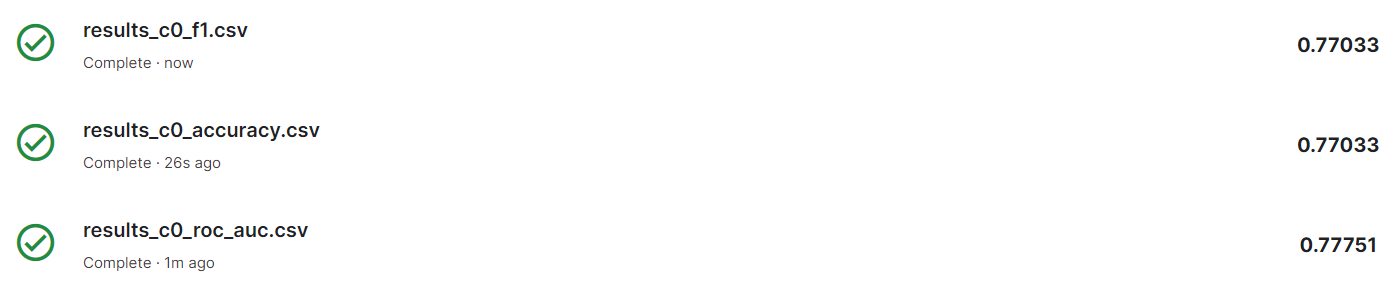

# 10 - DEPLOYMENT

Even though the final score was quite good for a 1st try and a deploy could already be though of, a 2nd cycle (c1) shall still be tested.

It will focus its efforts on trying to upgrade points from which more accuracy could possibly be extracted of, such as:

- Rescue of dropped features → in this case, `CABIN`, dropped since the beginning due to the high number of NAs
- Feature Engineering (tentative)
- EDA → extracting more insights that could help in modeling
- Data preparation (tentative) → modifying the scaling and encoding methods
- Feature Selection (tentative)
- Balancing the target feature

After this 2nd cycle, if there is enough time, a deploy shall be made with the best model, to make the predictions readily available. 